In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!unzip "/content/drive/MyDrive/CVSubset.zip" -d "/content/FLAME3_CV"

Mounted at /content/drive
Archive:  /content/drive/MyDrive/CVSubset.zip
   creating: /content/FLAME3_CV/FLAME 3 CV Dataset (Sycan Marsh)/
   creating: /content/FLAME3_CV/FLAME 3 CV Dataset (Sycan Marsh)/Fire/
   creating: /content/FLAME3_CV/FLAME 3 CV Dataset (Sycan Marsh)/Fire/RGB/
   creating: /content/FLAME3_CV/FLAME 3 CV Dataset (Sycan Marsh)/Fire/RGB/Corrected FOV/
  inflating: /content/FLAME3_CV/FLAME 3 CV Dataset (Sycan Marsh)/Fire/RGB/Corrected FOV/00001.JPG  
  inflating: /content/FLAME3_CV/FLAME 3 CV Dataset (Sycan Marsh)/Fire/RGB/Corrected FOV/00002.JPG  
  inflating: /content/FLAME3_CV/FLAME 3 CV Dataset (Sycan Marsh)/Fire/RGB/Corrected FOV/00003.JPG  
  inflating: /content/FLAME3_CV/FLAME 3 CV Dataset (Sycan Marsh)/Fire/RGB/Corrected FOV/00004.JPG  
  inflating: /content/FLAME3_CV/FLAME 3 CV Dataset (Sycan Marsh)/Fire/RGB/Corrected FOV/00005.JPG  
  inflating: /content/FLAME3_CV/FLAME 3 CV Dataset (Sycan Marsh)/Fire/RGB/Corrected FOV/00006.JPG  
  inflating: /content/FLAME

In [ ]:
import os

base_path = "/content/FLAME3_CV/FLAME 3 CV Dataset (Sycan Marsh)"

for root, dirs, files in os.walk(base_path):
    print(root, "->", len(files), "files")


/content/FLAME3_CV/FLAME 3 CV Dataset (Sycan Marsh) -> 0 files
/content/FLAME3_CV/FLAME 3 CV Dataset (Sycan Marsh)/No Fire -> 0 files
/content/FLAME3_CV/FLAME 3 CV Dataset (Sycan Marsh)/No Fire/Thermal -> 0 files
/content/FLAME3_CV/FLAME 3 CV Dataset (Sycan Marsh)/No Fire/Thermal/Celsius TIFF -> 116 files
/content/FLAME3_CV/FLAME 3 CV Dataset (Sycan Marsh)/No Fire/Thermal/Raw JPG -> 116 files
/content/FLAME3_CV/FLAME 3 CV Dataset (Sycan Marsh)/No Fire/RGB -> 0 files
/content/FLAME3_CV/FLAME 3 CV Dataset (Sycan Marsh)/No Fire/RGB/Corrected FOV -> 116 files
/content/FLAME3_CV/FLAME 3 CV Dataset (Sycan Marsh)/No Fire/RGB/Raw -> 116 files
/content/FLAME3_CV/FLAME 3 CV Dataset (Sycan Marsh)/Fire -> 0 files
/content/FLAME3_CV/FLAME 3 CV Dataset (Sycan Marsh)/Fire/Thermal -> 0 files
/content/FLAME3_CV/FLAME 3 CV Dataset (Sycan Marsh)/Fire/Thermal/Celsius TIFF -> 622 files
/content/FLAME3_CV/FLAME 3 CV Dataset (Sycan Marsh)/Fire/Thermal/Raw JPG -> 622 files
/content/FLAME3_CV/FLAME 3 CV Datase

In [ ]:
#Imports
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
#Paths
base_path = "/content/FLAME3_CV/FLAME 3 CV Dataset (Sycan Marsh)"
fire_path = os.path.join(base_path, "Fire/RGB/Corrected FOV")
nofire_path = os.path.join(base_path, "No Fire/RGB/Corrected FOV")

In [ ]:
#Parameters
IMG_SIZE = (224, 224)

In [ ]:
import numpy as np
import cv2
import os
from tensorflow.keras.utils import to_categorical

IMG_SIZE = (224,224)

def preprocess_image(img):
    # Resize
    img = cv2.resize(img, IMG_SIZE)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Noise reduction (Gaussian Blur)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)

    # Contrast enhancement (Histogram Equalization)
    equalized = cv2.equalizeHist(blur)

    # Normalize
    normalized = equalized / 255.0
    processed = cv2.merge([normalized, normalized, normalized])

    return processed

fire_path = os.path.join(base_path, "Fire/Thermal/Raw JPG")
nofire_path = os.path.join(base_path, "No Fire/Thermal/Raw JPG")

print("Fire samples:", len(os.listdir(fire_path)))
print("No Fire samples:", len(os.listdir(nofire_path)))


Fire samples: 622
No Fire samples: 116


In [ ]:
# Step 3: Function to load images
def load_images(folder, label):
    X, y = [], []
    for file in os.listdir(folder):
        if file.endswith(".JPG") or file.endswith(".jpg"):
            img = cv2.imread(os.path.join(folder, file))[:,:,::-1]  # BGR->RGB
            img = cv2.resize(img, IMG_SIZE)

            # --- 🔥 Preprocessing techniques ---
            # Convert to grayscale for contrast work
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

            # Noise reduction
            blur = cv2.GaussianBlur(gray, (5, 5), 0)

            # Contrast enhancement
            equalized = cv2.equalizeHist(blur)

            # Normalize 0–1
            normalized = equalized / 255.0

            # Expand back to 3 channels (for CNN expecting RGB)
            processed = cv2.merge([normalized, normalized, normalized])
            # --- 🔥 End preprocessing ---

            X.append(processed)
            y.append(label)
    return X, y

# Load Fire images
X_fire, y_fire = load_images(fire_path, 1)

# Load No Fire images
X_nofire, y_nofire = load_images(nofire_path, 0)

# Combine dataset
X = np.array(X_fire + X_nofire)
y = np.array(y_fire + y_nofire)

print("Dataset shape:", X.shape, y.shape)
print("Class distribution:", np.bincount(y))


Dataset shape: (738, 224, 224, 3) (738,)
Class distribution: [116 622]


In [ ]:
#train-test Split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

Train: (516, 224, 224, 3) Val: (111, 224, 224, 3) Test: (111, 224, 224, 3)


In [ ]:
#CNN Model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop]
)

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 450ms/step - accuracy: 0.6960 - loss: 0.9455 - val_accuracy: 0.8468 - val_loss: 0.3950
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - accuracy: 0.8241 - loss: 0.4543 - val_accuracy: 0.8468 - val_loss: 0.3271
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.8433 - loss: 0.3262 - val_accuracy: 0.9009 - val_loss: 0.2034
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.8816 - loss: 0.2329 - val_accuracy: 0.8649 - val_loss: 0.3156
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9008 - loss: 0.2424 - val_accuracy: 0.9189 - val_loss: 0.1622
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9532 - loss: 0.1176 - val_accuracy: 0.9910 - val_loss: 0.0581
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9758 - loss: 0.0693 - val_accuracy: 0.9099 - val_loss: 0.2317
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.9638 - loss: 0.0667 - val_accuracy: 0.9910 -

In [ ]:
#evaluate model
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc*100:.2f}%")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 0.0131
Test Accuracy: 100.00%


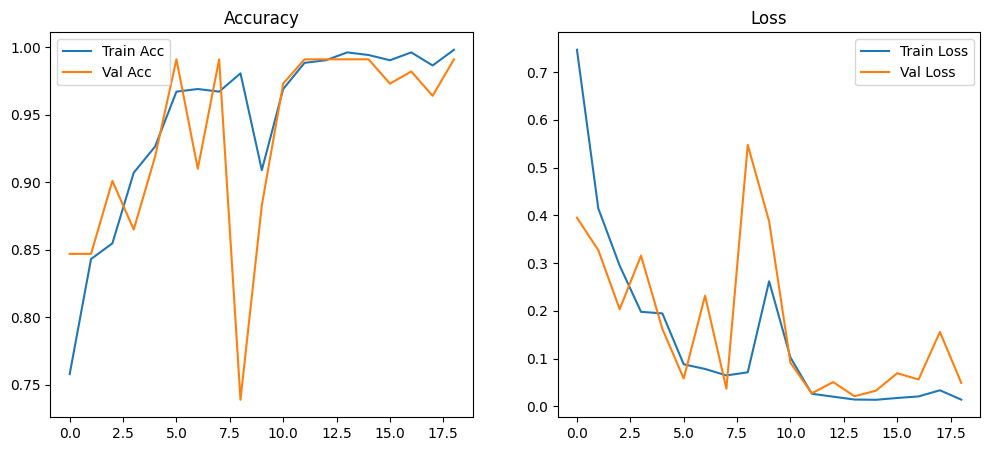

In [ ]:
#Plot Training History
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title("Loss")
plt.show()

In [ ]:
# data augmentation for no fire
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

In [ ]:
X_nofire_aug = []
y_nofire_aug = []

for img in X_nofire:
    img = np.expand_dims(img, 0)
    for batch in datagen.flow(img, batch_size=1):
        X_nofire_aug.append(batch[0])
        y_nofire_aug.append(0)
        if len(X_nofire_aug) >= (622 - 116):  #will match to fire images
            break

In [ ]:
#combine augmented images with original dataset
X_balanced = np.concatenate([X, np.array(X_nofire_aug)], axis=0)
y_balanced = np.concatenate([y, np.array(y_nofire_aug)], axis=0)

print("Balanced dataset shape:", X_balanced.shape, y_balanced.shape)

Balanced dataset shape: (1359, 224, 224, 3) (1359,)


In [ ]:
# Load Thermal images
def load_thermal(folder, img_list):
    thermal_imgs = []
    for file in img_list:
        img = cv2.imread(os.path.join(folder, file), cv2.IMREAD_UNCHANGED)
        img = cv2.resize(img, IMG_SIZE)
        img = img / 500.0  # normalization
        img = np.expand_dims(img, axis=-1)
        thermal_imgs.append(img)
    return np.array(thermal_imgs)

In [ ]:
fire_thermal_path = os.path.join(base_path, "Fire/Thermal/Celsius TIFF")
nofire_thermal_path = os.path.join(base_path, "No Fire/Thermal/Celsius TIFF")

fire_files = sorted(os.listdir(fire_thermal_path))
nofire_files = sorted(os.listdir(nofire_thermal_path))

In [ ]:
# thermal arrays
X_fire_thermal = load_thermal(fire_thermal_path, fire_files)
X_nofire_thermal = load_thermal(nofire_thermal_path, nofire_files)

# combine both image types
X_fire_rgb = np.array(X_fire)
X_nofire_rgb = np.array(X_nofire)

In [ ]:
X_fire_fusion = np.concatenate([X_fire_rgb, X_fire_thermal], axis=-1)
X_nofire_fusion = np.concatenate([X_nofire_rgb, X_nofire_thermal], axis=-1)

X_fusion = np.concatenate([X_fire_fusion, X_nofire_fusion], axis=0)
y_fusion = np.concatenate([np.ones(len(X_fire_fusion)), np.zeros(len(X_nofire_fusion))], axis=0)

print("Fusion dataset shape:", X_fusion.shape)

Fusion dataset shape: (738, 224, 224, 4)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

# split data for train,test and validation
X_train, X_temp, y_train, y_temp = train_test_split(X_fusion, y_fusion, test_size=0.3, stratify=y_fusion, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

Train: (516, 224, 224, 4) Val: (111, 224, 224, 4) Test: (111, 224, 224, 4)


In [ ]:
# write cnn model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,4)),  # 4 channels
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,377 (42.61 MB)

 Trainable params: 11,169,377 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#train model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop]
)


Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 283ms/step - accuracy: 0.8406 - loss: 0.8452 - val_accuracy: 0.8468 - val_loss: 0.3935
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.8371 - loss: 0.4072 - val_accuracy: 0.8468 - val_loss: 0.2367
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.8986 - loss: 0.1983 - val_accuracy: 0.8559 - val_loss: 0.1431
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.9234 - loss: 0.1580 - val_accuracy: 0.9730 - val_loss: 0.0725
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9661 - loss: 0.0836 - val_accuracy: 0.8829 - val_loss: 0.1805
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9487 - loss: 0.1031 - val_accuracy: 0.9820 - val_loss: 0.0413
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.9817 - loss: 0.0477 - val_accuracy: 1.0000 - val_loss: 0.0361
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.9911 - loss: 0.0312 - val_accuracy: 0.9730 -

In [ ]:
# evaluate
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc*100:.2f}%")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9943 - loss: 0.0116
Test Accuracy: 99.10%


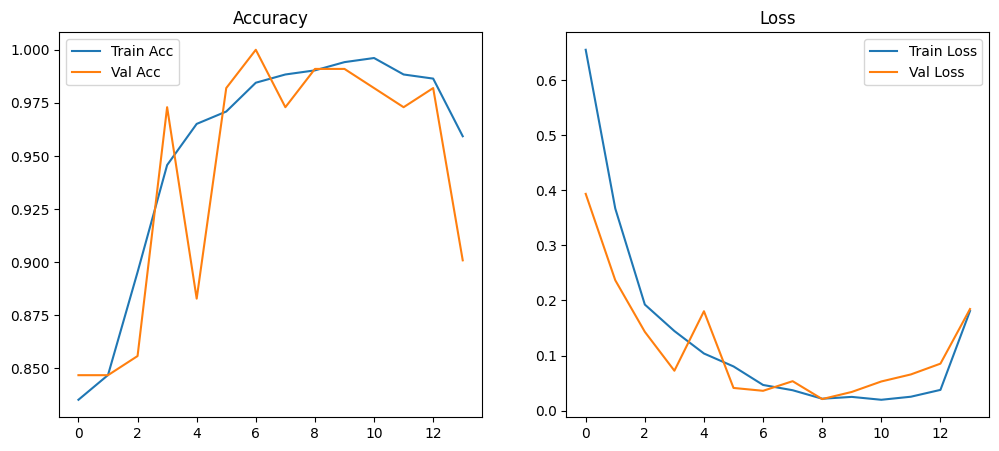

In [ ]:
#Plot Training History
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title("Loss")
plt.show()

In [ ]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()
from sklearn.metrics import classification_report, confusion_matrix

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step
Confusion Matrix:
[[18  0]
 [ 1 92]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97        18
         1.0       1.00      0.99      0.99        93

    accuracy                           0.99       111
   macro avg       0.97      0.99      0.98       111
weighted avg       0.99      0.99      0.99       111



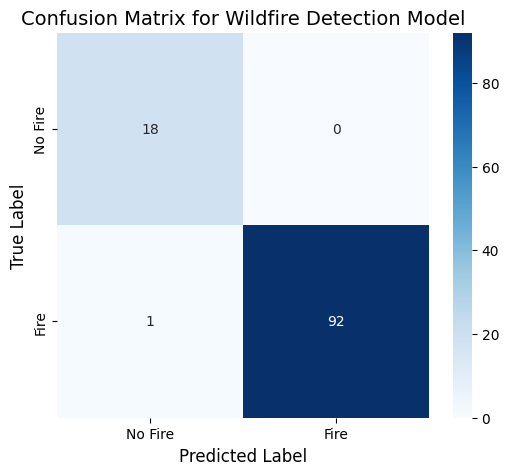

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

class_names = ['No Fire', 'Fire']

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix for Wildfire Detection Model', fontsize=14)
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


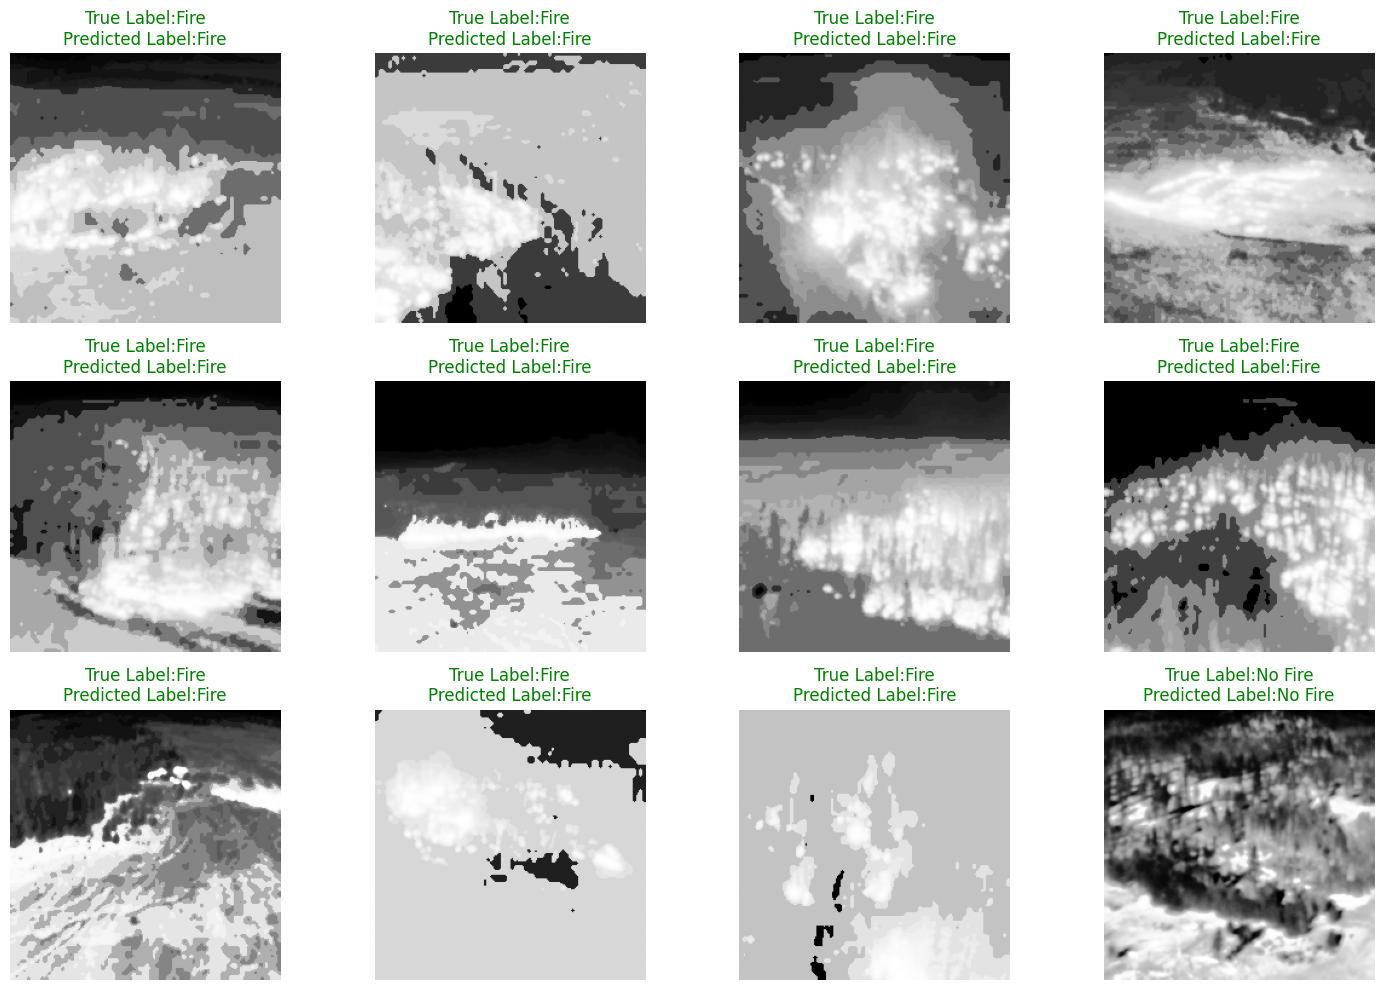

In [ ]:
import matplotlib.pyplot as plt

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

def plot_predictions(X, y_true, y_pred, num=12):
    plt.figure(figsize=(15,10))
    indices = np.random.choice(range(len(X)), num, replace=False)

    for i, idx in enumerate(indices):
        plt.subplot(3, 4, i+1)
        img = X[idx][:,:,:3]
        plt.imshow(img)
        plt.axis('off')
        true_label = "Fire" if y_true[idx]==1 else "No Fire"
        pred_label = "Fire" if y_pred[idx]==1 else "No Fire"
        color = 'green' if y_true[idx]==y_pred[idx] else 'red'
        plt.title(f"True Label:{true_label}\nPredicted Label:{pred_label}", color=color)
    plt.tight_layout()
    plt.show()

plot_predictions(X_test, y_test, y_pred, num=12)


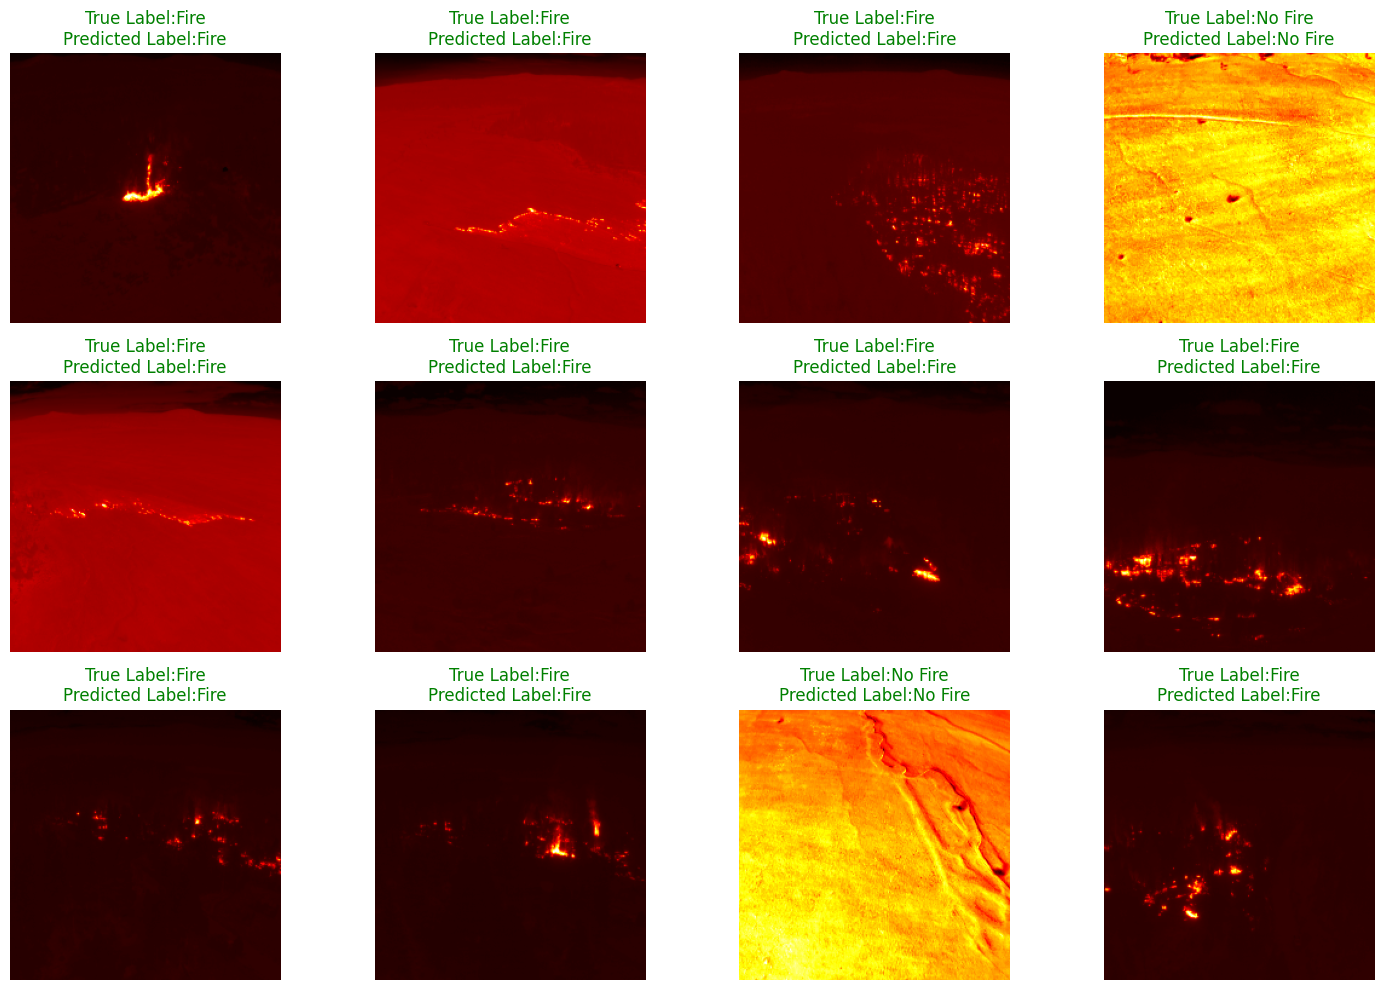

In [ ]:
import matplotlib.pyplot as plt

def plot_thermal_predictions(X_fusion, y_true, y_pred, num=12):
    plt.figure(figsize=(15,10))
    indices = np.random.choice(range(len(X_fusion)), num, replace=False)

    for i, idx in enumerate(indices):
        plt.subplot(3, 4, i+1)

        thermal = X_fusion[idx][:,:,3]
        plt.imshow(thermal, cmap='hot')
        plt.axis('off')

        true_label = "Fire" if y_true[idx]==1 else "No Fire"
        pred_label = "Fire" if y_pred[idx]==1 else "No Fire"
        color = 'green' if y_true[idx]==y_pred[idx] else 'red'
        plt.title(f"True Label:{true_label}\nPredicted Label:{pred_label}", color=color)

    plt.tight_layout()
    plt.show()

plot_thermal_predictions(X_test, y_test, y_pred, num=12)

In [ ]:

model.save("/content/wildfire_cnn.h5")


In [ ]:

!cp /content/wildfire_cnn.h5 /content/drive/MyDrive/
